## 📝 Project Documentation: Multitask Learning for Ticket Classification

### 📌 Overview
This project implements a **multitask learning model** to classify customer support tickets based on:
- **Issue Type** (e.g., technical problem, billing, late delivery)
- **Urgency Level** (e.g., low, medium, high)

The model is trained on a dataset of 1000+ annotated ticket complaints and addresses both tasks simultaneously using shared text and metadata features.

---

### 🔧 Key Design Choices

1. **Data Preprocessing**:
   - Cleaned and lemmatized text using `nltk`
   - Removed stopwords and punctuation
   - Engineered metadata features (e.g., text length, sentiment score, capital letters, exclamations)

2. **Feature Engineering**:
   - TF-IDF vectors for textual data
   - Sentiment polarity scores using `TextBlob`
   - Combined with scaled metadata features using `StandardScaler`

3. **Modeling Approaches**:

- **AutoML Framework: AutoGluon TabularPredictor**

  AutoGluon was used to automate the machine learning pipeline for two classification tasks:

  - Issue Type Classification
  - Urgency Level Classification

---

### 📊 Model Evaluation

#### **Issue Type Prediction**:
- Accuracy: 1.00


#### **Urgency Level Prediction**:
- Accuracy: 0.43

---

### ⚠️ Limitations

- Dataset is relatively small (~1000 samples), limiting generalization
- The model primarily uses classical methods
- Model performance is sensitive to text preprocessing and feature selection


In [1]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━

#Data preperation and libraries installation

In [2]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
df = pd.read_csv('/content/ai_dev_assignment_tickets_complex_1000.csv')

In [5]:
df_cleaned = df.dropna(subset=['ticket_text']).copy()
df_cleaned = df_cleaned.dropna(subset=['issue_type', 'urgency_level'])

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [8]:
df_cleaned['processed_text'] = df_cleaned['ticket_text'].apply(preprocess_text)

In [9]:
print(df_cleaned[['ticket_text', 'processed_text']].head())

                                         ticket_text  \
0  Payment issue for my SmartWatch V2. I was unde...   
2  I ordered SoundWave 300 but got EcoBreeze AC i...   
3  Facing installation issue with PhotoSnap Cam. ...   
5  Can you tell me more about the PhotoSnap Cam w...   
6   is malfunction. It stopped working after just...   

                                      processed_text  
0  payment issue smartwatch v2 underbilled order ...  
2  ordered soundwave 300 got ecobreeze ac instead...  
3  facing installation issue photosnap cam setup ...  
5     tell photosnap cam warranty also available red  
6                  malfunction stopped working 7 day  


#Feature Engineering

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
import numpy as np

In [11]:
df_cleaned['text_length'] = df_cleaned['processed_text'].apply(lambda x: len(x.split()))

In [12]:
complaint_keywords = ['broken', 'late', 'delay', 'error', 'issue', 'problem', 'cracked', 'missing']
def count_complaint_keywords(text):
    return sum(word in text.lower() for word in complaint_keywords)

df_cleaned['complaint_score'] = df_cleaned['ticket_text'].apply(count_complaint_keywords)
df_cleaned['num_exclamations'] = df_cleaned['ticket_text'].str.count('!')
df_cleaned['num_caps'] = df_cleaned['ticket_text'].apply(lambda x: sum(1 for c in x if c.isupper()))

df_cleaned['has_order_number'] = df_cleaned['ticket_text'].apply(lambda x: int(bool(re.search(r'#\d+', x))))

In [13]:
df_cleaned['sentiment'] = df_cleaned['ticket_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_cleaned['processed_text'])
metadata_features = df_cleaned[['text_length', 'sentiment', 'complaint_score', 'num_exclamations', 'num_caps', 'has_order_number']].values
scaler = StandardScaler()
metadata_scaled = scaler.fit_transform(metadata_features)

#Model training (seperate models) |Autogluon

In [14]:
from scipy.sparse import hstack
X_final = hstack([X_tfidf, metadata_scaled])

In [15]:
y_issue = df_cleaned['issue_type']
y_urgency = df_cleaned['urgency_level']

In [16]:
from autogluon.tabular import TabularPredictor
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
X_dense = pd.DataFrame(X_final.toarray())
issue_data = X_dense.copy()
issue_data['issue_type'] = y_issue.values

urgency_data = X_dense.copy()
urgency_data['urgency_level'] = y_urgency.values

from sklearn.model_selection import train_test_split
issue_train, issue_test = train_test_split(issue_data, test_size=0.2, random_state=42)
urgency_train, urgency_test = train_test_split(urgency_data, test_size=0.2, random_state=42)

issue_predictor = TabularPredictor(label='issue_type', path='autogluon_issue_model').fit(issue_train)
issue_performance = issue_predictor.evaluate(issue_test)

urgency_predictor = TabularPredictor(label='urgency_level', path='autogluon_urgency_model').fit(urgency_train)
urgency_performance = urgency_predictor.evaluate(urgency_test)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       10.88 GB / 12.67 GB (85.8%)
Disk Space Avail:   70.28 GB / 112.64 GB (62.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference s

#Multi-Task Learning (Single model) |Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
le_issue = LabelEncoder()
le_urgency = LabelEncoder()

In [ ]:
y_issue_enc = le_issue.fit_transform(y_issue)
y_urgency_enc = le_urgency.fit_transform(y_urgency)

In [ ]:
X_tensor = torch.tensor(X_final.toarray(), dtype=torch.float32)
y_issue_tensor = torch.tensor(y_issue_enc, dtype=torch.long)
y_urgency_tensor = torch.tensor(y_urgency_enc, dtype=torch.long)

In [ ]:
dataset = TensorDataset(X_tensor, y_issue_tensor, y_urgency_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
class MultiTaskNet(nn.Module):
    def __init__(self, input_dim, num_issue_classes, num_urgency_classes):
        super(MultiTaskNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.issue_head = nn.Linear(128, num_issue_classes)
        self.urgency_head = nn.Linear(128, num_urgency_classes)

    def forward(self, x):
        shared = self.shared(x)
        issue_out = self.issue_head(shared)
        urgency_out = self.urgency_head(shared)
        return issue_out, urgency_out

model = MultiTaskNet(input_dim=X_tensor.shape[1],
                     num_issue_classes=len(le_issue.classes_),
                     num_urgency_classes=len(le_urgency.classes_))

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
model.train()
epochs = 100

for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_issue_batch, y_urgency_batch in train_loader:
        optimizer.zero_grad()
        out_issue, out_urgency = model(X_batch)
        loss_issue = loss_fn(out_issue, y_issue_batch)
        loss_urgency = loss_fn(out_urgency, y_urgency_batch)
        loss = loss_issue + loss_urgency
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 5.4507
Epoch 2, Loss: 5.4815
Epoch 3, Loss: 5.3170
Epoch 4, Loss: 5.3582
Epoch 5, Loss: 5.3138
Epoch 6, Loss: 5.4217
Epoch 7, Loss: 5.4149
Epoch 8, Loss: 5.3402
Epoch 9, Loss: 5.3009
Epoch 10, Loss: 5.3235
Epoch 11, Loss: 5.2074
Epoch 12, Loss: 5.1914
Epoch 13, Loss: 5.3076
Epoch 14, Loss: 5.2637
Epoch 15, Loss: 5.1332
Epoch 16, Loss: 5.1258
Epoch 17, Loss: 5.3381
Epoch 18, Loss: 5.0346
Epoch 19, Loss: 5.1246
Epoch 20, Loss: 5.1238
Epoch 21, Loss: 5.0456
Epoch 22, Loss: 5.0161
Epoch 23, Loss: 5.1548
Epoch 24, Loss: 5.0662
Epoch 25, Loss: 4.9830
Epoch 26, Loss: 5.0270
Epoch 27, Loss: 4.9986
Epoch 28, Loss: 5.1282
Epoch 29, Loss: 5.0047
Epoch 30, Loss: 4.9691
Epoch 31, Loss: 4.9139
Epoch 32, Loss: 4.9770
Epoch 33, Loss: 4.8018
Epoch 34, Loss: 5.0330
Epoch 35, Loss: 4.9242
Epoch 36, Loss: 4.7212
Epoch 37, Loss: 4.9416
Epoch 38, Loss: 4.8132
Epoch 39, Loss: 4.9317
Epoch 40, Loss: 4.7039
Epoch 41, Loss: 4.9185
Epoch 42, Loss: 4.8355
Epoch 43, Loss: 4.7394
Epoch 44, Loss: 4.69

In [ ]:
model.eval()
with torch.no_grad():
    pred_issue_logits, pred_urgency_logits = model(X_tensor)
    pred_issue = torch.argmax(pred_issue_logits, dim=1)
    pred_urgency = torch.argmax(pred_urgency_logits, dim=1)

from sklearn.metrics import classification_report

print("Issue Type Report:\n", classification_report(y_issue_enc, pred_issue.numpy(), target_names=le_issue.classes_))
print("Urgency Level Report:\n", classification_report(y_urgency_enc, pred_urgency.numpy(), target_names=le_urgency.classes_))

Issue Type Report:
                     precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00       133
   Billing Problem       1.00      1.00      1.00       128
   General Inquiry       1.00      1.00      1.00       127
Installation Issue       1.00      1.00      1.00       128
     Late Delivery       1.00      1.00      1.00        97
    Product Defect       1.00      1.00      1.00       110
        Wrong Item       1.00      1.00      1.00       103

          accuracy                           1.00       826
         macro avg       1.00      1.00      1.00       826
      weighted avg       1.00      1.00      1.00       826

Urgency Level Report:
               precision    recall  f1-score   support

        High       0.81      0.87      0.84       288
         Low       0.81      0.82      0.81       260
      Medium       0.86      0.79      0.82       278

    accuracy                           0.83       826
   macro avg       0.8

#Entity Extraction

In [17]:
from dateutil import parser
from typing import Dict, List

In [18]:
product_list = set(df['product'].dropna().unique())

In [19]:
complaint_keywords = [
    'broken', 'late', 'delay', 'error', 'issue', 'problem',
    'cracked', 'missing', 'damaged', 'faulty', 'not working',
    'defective', 'glitch', 'failed', 'doesn’t work', 'stuck'
]

In [20]:
def extract_entities(text: str) -> Dict[str, List[str]]:
    text_lower = text.lower()
    found_products = [prod for prod in product_list if prod.lower() in text_lower]
    found_keywords = [kw for kw in complaint_keywords if re.search(rf'\b{re.escape(kw)}\b', text_lower)]
    date_patterns = re.findall(
        r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}'
        r'|\d{1,2}(st|nd|rd|th)?\s+\w+\s+\d{2,4}'
        r'|\w+\s+\d{1,2},\s+\d{4})',
        text
    )
    extracted_dates = []
    for date_tuple in date_patterns:
        date_text = date_tuple[0]
        try:
            parsed_date = parser.parse(date_text, fuzzy=True)
            extracted_dates.append(str(parsed_date.date()))
        except Exception:
            continue

    return {
        'products': found_products,
        'complaint_keywords': found_keywords,
        'dates': extracted_dates
    }

In [21]:
ticket_text = df.loc[0, 'ticket_text']
entities = extract_entities(ticket_text)
print("Ticket Text:", ticket_text)
print("Extracted Entities:", entities)

Ticket Text: Payment issue for my SmartWatch V2. I was underbilled for order #29224.
Extracted Entities: {'products': ['SmartWatch V2'], 'complaint_keywords': ['issue'], 'dates': []}


#Integration

In [22]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from scipy.sparse import hstack
from autogluon.tabular import TabularPredictor
import pandas as pd

In [23]:
def process_ticket(ticket_text: str) -> Dict[str, object]:
    import re
    from textblob import TextBlob
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.preprocessing import StandardScaler
    from scipy.sparse import hstack
    import pandas as pd
    text_processed = re.sub(r'[^a-zA-Z0-9\s]', '', ticket_text.lower())

    text_length = len(text_processed.split())
    sentiment = TextBlob(ticket_text).sentiment.polarity
    complaint_score = sum(word in text_processed for word in complaint_keywords)
    num_exclamations = ticket_text.count('!')
    num_caps = sum(1 for c in ticket_text if c.isupper())
    has_order_number = int(bool(re.search(r'#\d+', ticket_text)))
    tfidf_vector = tfidf.transform([text_processed])
    metadata_vector = scaler.transform([[text_length, sentiment, complaint_score, num_exclamations, num_caps, has_order_number]])

    final_features = hstack([tfidf_vector, metadata_vector])
    df_input = pd.DataFrame(final_features.toarray())
    issue_pred = issue_predictor.predict(df_input)[0]
    urgency_pred = urgency_predictor.predict(df_input)[0]
    entities = extract_entities(ticket_text)
    return issue_pred, urgency_pred, entities
    # return {
    #     'predicted_issue_type': issue_pred,
    #     'predicted_urgency_level': urgency_pred,
    #     'extracted_entities': entities
    # }


In [24]:
sample_ticket = "Order #12345 for UltraClean Vacuum is still not delivered. It was due on April 20, 2023! This is really frustrating!"
output = process_ticket(sample_ticket)
print(output)

('Late Delivery', 'Low', {'products': ['UltraClean Vacuum'], 'complaint_keywords': [], 'dates': ['2023-04-20']})


#Class Imbalance

Issue Type Distribution:
 issue_type
Account Access        110
Billing Problem       109
General Inquiry       102
Installation Issue     99
Late Delivery          80
Product Defect         80
Wrong Item             80
Name: count, dtype: int64


<ipython-input-25-1e08e70196aa>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=issue_counts.index, y=issue_counts.values, palette='viridis')


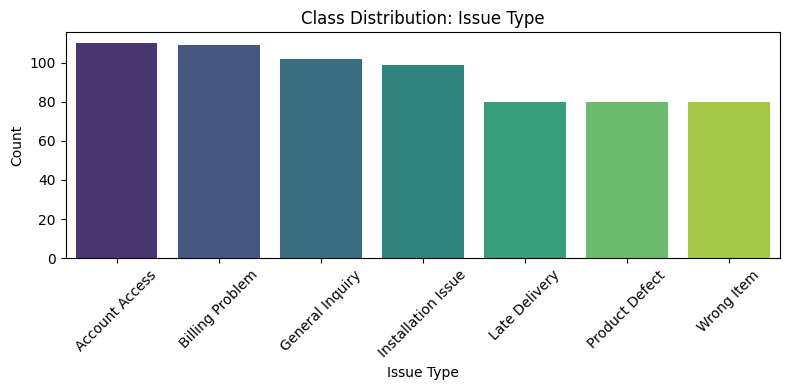


Urgency Level Distribution:
 urgency_level
High      222
Medium    221
Low       217
Name: count, dtype: int64


<ipython-input-25-1e08e70196aa>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=urgency_counts.index, y=urgency_counts.values, palette='coolwarm')


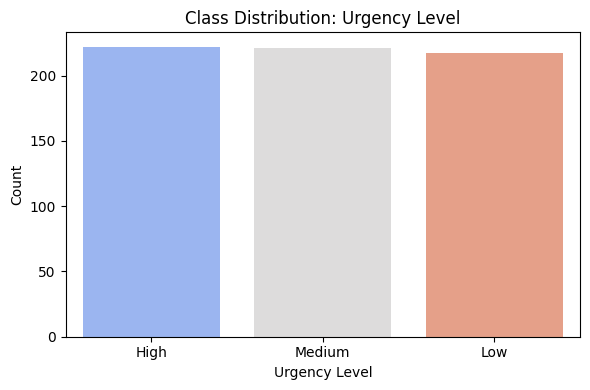

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# For issue_type
issue_counts = issue_train['issue_type'].value_counts()
print("Issue Type Distribution:\n", issue_counts)

# Bar plot for issue_type
plt.figure(figsize=(8, 4))
sns.barplot(x=issue_counts.index, y=issue_counts.values, palette='viridis')
plt.title('Class Distribution: Issue Type')
plt.ylabel('Count')
plt.xlabel('Issue Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For urgency_level
urgency_counts = urgency_train['urgency_level'].value_counts()
print("\nUrgency Level Distribution:\n", urgency_counts)

# Bar plot for urgency_level
plt.figure(figsize=(6, 4))
sns.barplot(x=urgency_counts.index, y=urgency_counts.values, palette='coolwarm')
plt.title('Class Distribution: Urgency Level')
plt.ylabel('Count')
plt.xlabel('Urgency Level')
plt.tight_layout()
plt.show()


#downloading Model

In [ ]:
!zip -r autogluon_issue_model.zip autogluon_issue_model/

  adding: autogluon_issue_model/ (stored 0%)
  adding: autogluon_issue_model/utils/ (stored 0%)
  adding: autogluon_issue_model/utils/attr/ (stored 0%)
  adding: autogluon_issue_model/utils/attr/ExtraTreesEntr/ (stored 0%)
  adding: autogluon_issue_model/utils/attr/ExtraTreesEntr/y_pred_proba_val.pkl (deflated 72%)
  adding: autogluon_issue_model/utils/attr/KNeighborsUnif/ (stored 0%)
  adding: autogluon_issue_model/utils/attr/KNeighborsUnif/y_pred_proba_val.pkl (deflated 89%)
  adding: autogluon_issue_model/utils/attr/LightGBMXT/ (stored 0%)
  adding: autogluon_issue_model/utils/attr/LightGBMXT/y_pred_proba_val.pkl (deflated 21%)
  adding: autogluon_issue_model/utils/attr/XGBoost/ (stored 0%)
  adding: autogluon_issue_model/utils/attr/XGBoost/y_pred_proba_val.pkl (deflated 83%)
  adding: autogluon_issue_model/utils/attr/RandomForestEntr/ (stored 0%)
  adding: autogluon_issue_model/utils/attr/RandomForestEntr/y_pred_proba_val.pkl (deflated 74%)
  adding: autogluon_issue_model/utils/att

In [ ]:
!zip -r autogluon_urgency_model.zip autogluon_urgency_model/

  adding: autogluon_urgency_model/ (stored 0%)
  adding: autogluon_urgency_model/utils/ (stored 0%)
  adding: autogluon_urgency_model/utils/attr/ (stored 0%)
  adding: autogluon_urgency_model/utils/attr/ExtraTreesEntr/ (stored 0%)
  adding: autogluon_urgency_model/utils/attr/ExtraTreesEntr/y_pred_proba_val.pkl (deflated 17%)
  adding: autogluon_urgency_model/utils/attr/KNeighborsUnif/ (stored 0%)
  adding: autogluon_urgency_model/utils/attr/KNeighborsUnif/y_pred_proba_val.pkl (deflated 77%)
  adding: autogluon_urgency_model/utils/attr/LightGBMXT/ (stored 0%)
  adding: autogluon_urgency_model/utils/attr/LightGBMXT/y_pred_proba_val.pkl (deflated 35%)
  adding: autogluon_urgency_model/utils/attr/XGBoost/ (stored 0%)
  adding: autogluon_urgency_model/utils/attr/XGBoost/y_pred_proba_val.pkl (deflated 15%)
  adding: autogluon_urgency_model/utils/attr/RandomForestEntr/ (stored 0%)
  adding: autogluon_urgency_model/utils/attr/RandomForestEntr/y_pred_proba_val.pkl (deflated 17%)
  adding: autog

#Gradio

In [26]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.8 MB/s eta 0:00:00


In [27]:
import gradio as gr

In [ ]:
iface = gr.Interface(
    fn=process_ticket,
    inputs=gr.Textbox(lines=5, placeholder="Paste a support ticket here..."),
    outputs=[
        gr.Label(label="Predicted Issue Type"),
        gr.Label(label="Predicted Urgency Level"),
        gr.JSON(label="Extracted Entities")
    ],
    title="Customer Support Ticket Classifier",
    description="Enter a customer support ticket. This app predicts the issue type, urgency, and extracts relevant entities."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://255e0216896bd594f1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
